# CNN 1D — MSE vs Itakura–Saito (IS) — Hessian top-k
Ce notebook entraîne un **petit CNN 1D** sur un jeu de données synthétique (cibles strictement positives), compare **MSE vs IS**, puis estime le **top-k du spectre du Hessien** par **Lanczos** avec produits Hessien-vecteur (autograd).  
Les figures et résultats sont enregistrés dans `./outputs/`.


In [19]:
from IPython.display import display,HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:
import os, json, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# %matplotlib inline  # décommenter si besoin

torch.set_num_threads(max(1, os.cpu_count()//2))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng = np.random.default_rng(0)
torch.manual_seed(0)
np.random.seed(0)

print("Device:", device)


Device: cuda


In [2]:
def make_dataset(n_samples=512, length=96, noise=0.05):
    t = np.linspace(0, 2*np.pi, length, endpoint=False)
    X, Y = [], []
    for _ in range(n_samples):
        f1, f2 = rng.uniform(1.0, 3.0), rng.uniform(3.0, 6.0)
        p1, p2 = rng.uniform(0, 2*np.pi), rng.uniform(0, 2*np.pi)
        sig = 0.6*np.sin(f1*t+p1) + 0.4*np.sin(f2*t+p2)
        env = 0.8 + 0.6*np.sin(0.5*t + p1/2.0) + 0.2*np.cos(0.25*t + p2/2.0)
        env = env - env.min() + 1e-1  # >0 pour IS
        x = sig + noise*np.random.standard_normal(length)
        X.append(x.astype(np.float32))
        Y.append(env.astype(np.float32))
    X = np.stack(X)[:, None, :]  # [N,1,L]
    Y = np.stack(Y)[:, None, :]
    return torch.tensor(X), torch.tensor(Y)

X, Y = make_dataset(n_samples=512, length=96, noise=0.05)
n_train = int(0.85*len(X))
X_train, Y_train = X[:n_train], Y[:n_train]
X_val,   Y_val   = X[n_train:], Y[n_train:]
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val,   Y_val),   batch_size=64, shuffle=False)

X.shape, Y.shape, len(train_loader), len(val_loader)


(torch.Size([512, 1, 96]), torch.Size([512, 1, 96]), 7, 2)

In [3]:
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(8, 8, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(8, 1, kernel_size=3, padding=1)
        self.softplus = nn.Softplus(beta=1.0, threshold=20.0)  # sortie >0
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return self.softplus(x)

def n_params(m): 
    return sum(p.numel() for p in m.parameters())


In [4]:
def loss_mse(pred, target):
    return F.mse_loss(pred, target)

def loss_is(pred, target, eps=1e-8):
    # IS(y||phi) = y/phi - log(y/phi) - 1 ; y,phi>0
    phi = torch.clamp(pred, min=eps)
    y = torch.clamp(target, min=eps)
    r = y/phi
    return (r - torch.log(r) - 1.0).mean()


In [5]:
def train_model(loss_fn, epochs=8, lr=1e-3, wd=1e-4):
    model = TinyCNN().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    tr_hist, val_hist = [], []
    for ep in range(epochs):
        model.train(); ep_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            ep_loss += loss.item() * xb.size(0)
        tr_hist.append(ep_loss/len(train_loader.dataset))

        model.eval(); vloss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                vloss += loss_fn(pred, yb).item() * xb.size(0)
        val_hist.append(vloss/len(val_loader.dataset))
    return model, tr_hist, val_hist


In [6]:
def hvp(loss, model, v_flat):
    """
    Produit Hessien-vecteur H·v via double backprop.
    v_flat : vecteur plat (1D) de taille égale à concat([p.grad]) sur tous les params.
    """
    params = [p for p in model.parameters() if p.requires_grad]
    # 1) g_flat = ∂L/∂θ (concaténé)
    grads = torch.autograd.grad(loss, params, create_graph=True)
    g_flat = torch.cat([g.reshape(-1) for g in grads])
    # 2) Hv : dérivée de (g_flat @ v_flat) w.r.t. θ
    gv = torch.dot(g_flat, v_flat)
    Hv_tensors = torch.autograd.grad(gv, params, retain_graph=True)
    Hv_flat = torch.cat([h.reshape(-1) for h in Hv_tensors])
    return Hv_flat

def topk_hessian_eigs(model, loss_fn, loader, k=20, batch_items=24, seed=0):
    """
    Lanczos (k étapes) sur la Hessienne définie par la loss full-batch d'une petite sous-batch.
    Renvoie les k VP approx triées décroissantes.
    """
    torch.manual_seed(seed)
    device = next(model.parameters()).device

    # petite sous-batch pour définir la Hessienne
    xb, yb = next(iter(loader))
    xb, yb = xb[:batch_items].to(device), yb[:batch_items].to(device)
    model.zero_grad(set_to_none=True)
    model.eval()  # (optionnel) pas indispensable ici
    pred = model(xb)
    loss = loss_fn(pred, yb)

    params = [p for p in model.parameters() if p.requires_grad]
    n = sum(p.numel() for p in params)

    # Lanczos
    Q = torch.zeros((n, k), device=device)
    T = torch.zeros((k, k), device=device)

    v = torch.randn(n, device=device)
    v = v / (v.norm() + 1e-12)
    beta = 0.0

    for j in range(k):
        Q[:, j] = v
        Hv = hvp(loss, model, v)            # <-- v est PLAT
        alpha = torch.dot(v, Hv)
        w = Hv - alpha * v
        if j > 0:
            w = w - beta * Q[:, j-1]
        beta = w.norm()
        T[j, j] = alpha
        if j < k-1:
            T[j, j+1] = beta
            T[j+1, j] = beta

        if beta < 1e-10 and j < k-1:
            # redémarre si vecteur résiduel trop petit
            v = torch.randn(n, device=device)
            v = v / (v.norm() + 1e-12)
            beta = 0.0
        else:
            v = w / (beta + 1e-12)

    evals = torch.linalg.eigvalsh(T).detach().cpu().numpy()
    return np.sort(evals)[::-1]

def to_coords(vals):
    return " ".join(f"({i},{float(v):.6g})" for i,v in enumerate(vals))

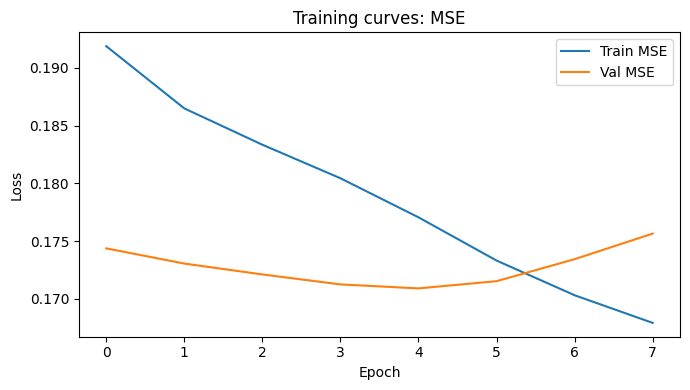

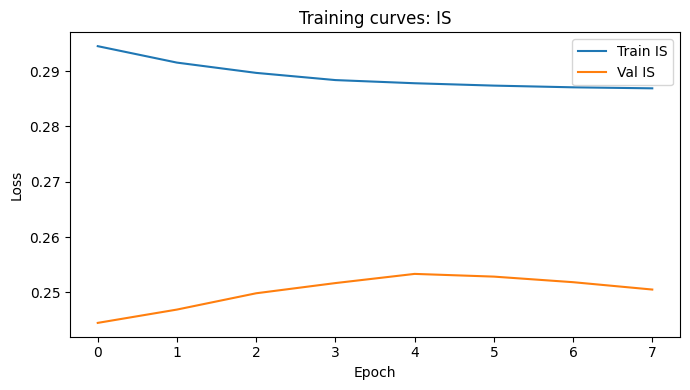

In [7]:
os.makedirs("outputs", exist_ok=True)
model_mse, tr_mse, val_mse = train_model(loss_mse, epochs=8)
model_is,  tr_is,  val_is  = train_model(loss_is,  epochs=8)

plt.figure(figsize=(7,4))
plt.plot(tr_mse, label="Train MSE"); plt.plot(val_mse, label="Val MSE")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training curves: MSE")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(tr_is, label="Train IS"); plt.plot(val_is, label="Val IS")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training curves: IS")
plt.legend(); plt.tight_layout(); plt.show()


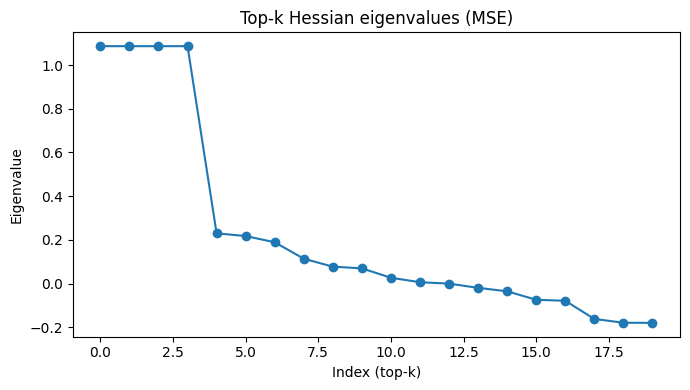

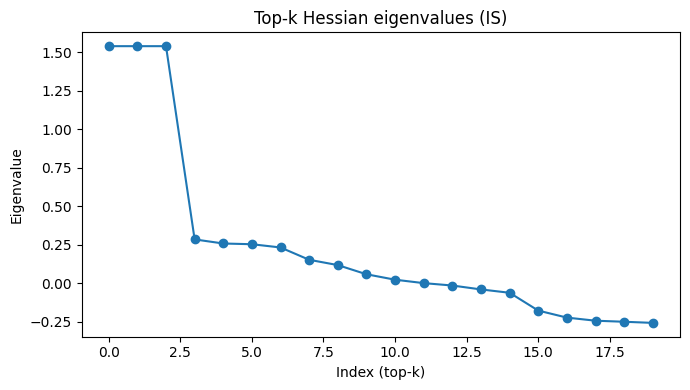

Saved results to outputs/exp_cnn1d_is_vs_mse_results.json


In [8]:
k = 20
evals_mse = topk_hessian_eigs(model_mse, loss_mse, train_loader, k=k, batch_items=24)
evals_is  = topk_hessian_eigs(model_is,  loss_is,  train_loader, k=k, batch_items=24)

plt.figure(figsize=(7,4))
plt.plot(evals_mse, marker="o")
plt.xlabel("Index (top-k)"); plt.ylabel("Eigenvalue"); plt.title("Top-k Hessian eigenvalues (MSE)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(evals_is, marker="o")
plt.xlabel("Index (top-k)"); plt.ylabel("Eigenvalue"); plt.title("Top-k Hessian eigenvalues (IS)")
plt.tight_layout(); plt.show()

with open("outputs/exp_cnn1d_is_vs_mse_results.json","w") as f:
    json.dump(dict(
        device=str(device),
        n_params=int(sum(p.numel() for p in model_mse.parameters())),
        train_mse=list(map(float,tr_mse)),
        val_mse=list(map(float,val_mse)),
        train_is=list(map(float,tr_is)),
        val_is=list(map(float,val_is)),
        topk_eigs_mse=list(map(float,evals_mse)),
        topk_eigs_is=list(map(float,evals_is)),
    ), f, indent=2)
print("Saved results to outputs/exp_cnn1d_is_vs_mse_results.json")


In [9]:
print(to_coords(evals_mse))  # colle le résultat dans \cnnMSE, etc.
print(to_coords(evals_is))  # colle le résultat dans \cnnIS, etc.

(0,1.08619) (1,1.08616) (2,1.08615) (3,1.08615) (4,0.230114) (5,0.21751) (6,0.189129) (7,0.113827) (8,0.0774637) (9,0.0696674) (10,0.0267159) (11,0.00632148) (12,-0.000130399) (13,-0.0195031) (14,-0.0352815) (15,-0.0740142) (16,-0.0786558) (17,-0.161706) (18,-0.179015) (19,-0.179772)
(0,1.53907) (1,1.53906) (2,1.53905) (3,0.284079) (4,0.257576) (5,0.252804) (6,0.23174) (7,0.151753) (8,0.117321) (9,0.0577664) (10,0.0223899) (11,0.000220102) (12,-0.0153591) (13,-0.0407315) (14,-0.0624398) (15,-0.178199) (16,-0.223652) (17,-0.243859) (18,-0.250661) (19,-0.258002)


In [10]:
# --- Blocs résiduels 1D ---
class ResBlock1D(nn.Module):
    def __init__(self, channels, k=5, dilation=1):
        super().__init__()
        pad = (k-1)//2 * dilation
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=5, padding=pad, dilation=dilation)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=5, padding=pad, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(channels)
        self.bn2 = nn.BatchNorm1d(channels)
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        return F.relu(x + y)

class ResNet1D(nn.Module):
    def __init__(self, base=8):
        super().__init__()
        self.inp = nn.Conv1d(1, base, kernel_size=5, padding=2)
        self.b1 = ResBlock1D(base, dilation=1)
        self.b2 = ResBlock1D(base, dilation=2)
        self.b3 = ResBlock1D(base, dilation=4)
        self.out = nn.Conv1d(base, 1, kernel_size=3, padding=1)
        self.softplus = nn.Softplus(beta=1.0, threshold=20.0)  # sortie > 0
    def forward(self, x):
        x = F.relu(self.inp(x))
        x = self.b1(x); x = self.b2(x); x = self.b3(x)
        x = self.out(x)
        return self.softplus(x)

# --- MLP 1D (point-wise) ---
class MLP1D(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        # traite chaque pas temporel indépendamment (1x1 conv = MLP partagé)
        self.fc1 = nn.Conv1d(1, hidden, kernel_size=1)
        self.fc2 = nn.Conv1d(hidden, hidden, kernel_size=1)
        self.fc3 = nn.Conv1d(hidden, 1, kernel_size=1)
        self.softplus = nn.Softplus(beta=1.0, threshold=20.0)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softplus(x)

# --- Fabrique de modèles ---
def make_model(name="cnn"):
    name = name.lower()
    if name == "cnn":
        return TinyCNN()
    if name == "resnet":
        return ResNet1D(base=8)
    if name == "mlp":
        return MLP1D(hidden=64)
    raise ValueError(f"Unknown model name: {name}")


In [11]:
MODEL_NAME = "resnet"  # "cnn" (par défaut), "resnet", ou "mlp"

def train_model(loss_fn, epochs=8, lr=1e-3, wd=1e-4):
    model = make_model(MODEL_NAME).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    tr_hist, val_hist = [], []
    for ep in range(epochs):
        model.train(); ep_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            ep_loss += loss.item() * xb.size(0)
        tr_hist.append(ep_loss/len(train_loader.dataset))
        model.eval(); vloss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                vloss += loss_fn(pred, yb).item() * xb.size(0)
        val_hist.append(vloss/len(val_loader.dataset))
    return model, tr_hist, val_hist


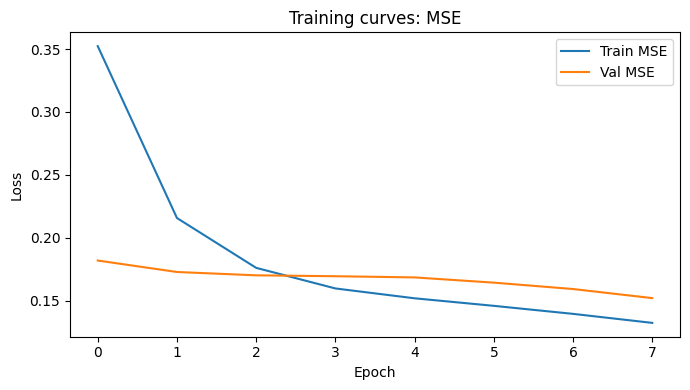

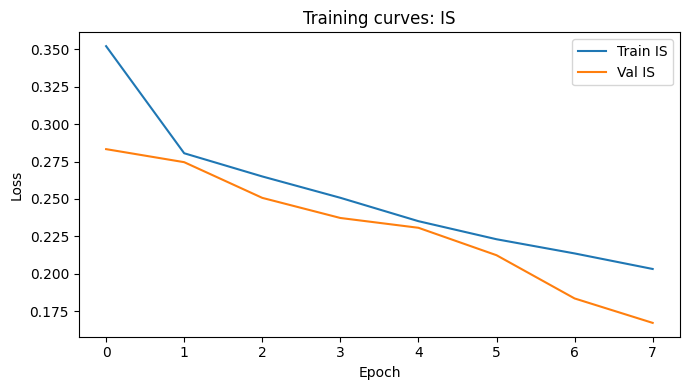

In [12]:
os.makedirs("outputs", exist_ok=True)
model_mse, tr_mse, val_mse = train_model(loss_mse, epochs=8)
model_is,  tr_is,  val_is  = train_model(loss_is,  epochs=8)

plt.figure(figsize=(7,4))
plt.plot(tr_mse, label="Train MSE"); plt.plot(val_mse, label="Val MSE")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training curves: MSE")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(tr_is, label="Train IS"); plt.plot(val_is, label="Val IS")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training curves: IS")
plt.legend(); plt.tight_layout(); plt.show()


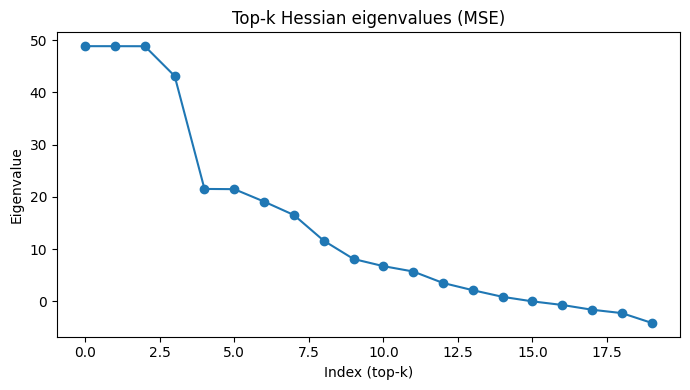

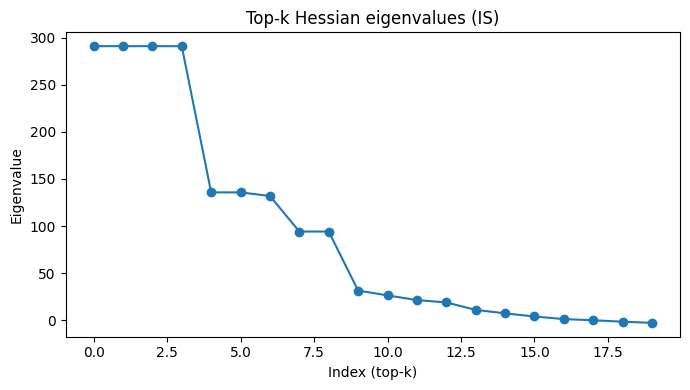

Saved results to outputs/exp_cnn1d_is_vs_mse_results.json


In [13]:
k = 20
evals_mse = topk_hessian_eigs(model_mse, loss_mse, train_loader, k=k, batch_items=24)
evals_is  = topk_hessian_eigs(model_is,  loss_is,  train_loader, k=k, batch_items=24)

plt.figure(figsize=(7,4))
plt.plot(evals_mse, marker="o")
plt.xlabel("Index (top-k)"); plt.ylabel("Eigenvalue"); plt.title("Top-k Hessian eigenvalues (MSE)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(evals_is, marker="o")
plt.xlabel("Index (top-k)"); plt.ylabel("Eigenvalue"); plt.title("Top-k Hessian eigenvalues (IS)")
plt.tight_layout(); plt.show()

with open("outputs/exp_cnn1d_is_vs_mse_results.json","w") as f:
    json.dump(dict(
        device=str(device),
        n_params=int(sum(p.numel() for p in model_mse.parameters())),
        train_mse=list(map(float,tr_mse)),
        val_mse=list(map(float,val_mse)),
        train_is=list(map(float,tr_is)),
        val_is=list(map(float,val_is)),
        topk_eigs_mse=list(map(float,evals_mse)),
        topk_eigs_is=list(map(float,evals_is)),
    ), f, indent=2)
print("Saved results to outputs/exp_cnn1d_is_vs_mse_results.json")


In [14]:
print(to_coords(evals_mse))  # colle le résultat dans \resMSE, etc.
print(to_coords(evals_is))  # colle le résultat dans \resIS, etc.

(0,48.833) (1,48.8305) (2,48.8219) (3,43.1208) (4,21.5179) (5,21.4771) (6,19.0952) (7,16.5263) (8,11.62) (9,8.11678) (10,6.74797) (11,5.72283) (12,3.53136) (13,2.14493) (14,0.876705) (15,0.00780755) (16,-0.680358) (17,-1.59165) (18,-2.23743) (19,-4.10833)
(0,290.946) (1,290.944) (2,290.939) (3,290.914) (4,135.745) (5,135.744) (6,131.928) (7,94.1933) (8,94.1828) (9,31.5272) (10,26.4) (11,21.4166) (12,18.9207) (13,11.0231) (14,7.31893) (15,4.01007) (16,1.2359) (17,-0.0107413) (18,-1.50284) (19,-2.78732)


In [15]:
MODEL_NAME = "transformer"   # "cnn", "resnet", "mlp", "transformer"

import math

class SinusoidalPE1D(nn.Module):
    def __init__(self, d_model, max_len=2048):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # [1, L, d]
    def forward(self, x):  # x: [B,L,d]
        return x + self.pe[:, :x.size(1), :]

class LocalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads=4, win=9):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.win = win
        # projections 1x1 (équiv. Conv1d kernel=1)
        self.q = nn.Conv1d(d_model, d_model, kernel_size=1)
        self.k = nn.Conv1d(d_model, d_model, kernel_size=1)
        self.v = nn.Conv1d(d_model, d_model, kernel_size=1)
        self.o = nn.Conv1d(d_model, d_model, kernel_size=1)

    def forward(self, x):  # x: [B,L,d]
        B,L,d = x.shape
        # -> [B,d,L] pour conv1d
        xt = x.transpose(1,2)
        q = self.q(xt).transpose(1,2).view(B,L,self.n_heads,self.d_head)  # [B,L,H,Dh]
        k = self.k(xt).transpose(1,2).view(B,L,self.n_heads,self.d_head)
        v = self.v(xt).transpose(1,2).view(B,L,self.n_heads,self.d_head)

        # normalisation d'échelle
        q = q / math.sqrt(self.d_head)

        # attention locale par fenêtre centrée (padding aux bords)
        pad = self.win // 2
        k_pad = F.pad(k.transpose(1,2), (0,0,pad,pad))  # [B,H,L+2p,Dh]
        v_pad = F.pad(v.transpose(1,2), (0,0,pad,pad))
        outs = []
        for i in range(L):
            k_slice = k_pad[:,:,i:i+self.win,:]      # [B,H,win,Dh]
            v_slice = v_pad[:,:,i:i+self.win,:]      # [B,H,win,Dh]
            q_i = q[:,i,:,:].unsqueeze(-2)           # [B,H,1,Dh]
            logits = (q_i * k_slice).sum(-1)         # [B,H,win]
            att = torch.softmax(logits, dim=-1)      # [B,H,win]
            out_i = (att.unsqueeze(-1) * v_slice).sum(-2)  # [B,H,Dh]
            outs.append(out_i)
        out = torch.stack(outs, dim=1)               # [B,L,H,Dh]
        out = out.reshape(B,L,self.d_model).transpose(1,2) # [B,d,L]
        out = self.o(out).transpose(1,2)             # [B,L,d]
        return out

class TransformerBlock1D(nn.Module):
    def __init__(self, d_model=32, n_heads=4, win=9, mlp_ratio=2):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = LocalSelfAttention(d_model, n_heads=n_heads, win=win)
        self.norm2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_ratio*d_model),
            nn.GELU(),
            nn.Linear(mlp_ratio*d_model, d_model),
        )

    def forward(self, x):  # [B,L,d]
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class Transformer1D(nn.Module):
    def __init__(self, d_model=32, n_heads=4, depth=3, win=9):
        super().__init__()
        self.inp = nn.Conv1d(1, d_model, kernel_size=3, padding=1)
        self.pe = SinusoidalPE1D(d_model)
        self.blocks = nn.ModuleList([TransformerBlock1D(d_model, n_heads, win) for _ in range(depth)])
        self.out = nn.Conv1d(d_model, 1, kernel_size=3, padding=1)
        self.softplus = nn.Softplus(beta=1.0, threshold=20.0)
    def forward(self, x):  # x: [B,1,L]
        h = self.inp(x).transpose(1,2)   # [B,L,d]
        h = self.pe(h)
        for blk in self.blocks:
            h = blk(h)
        h = h.transpose(1,2)             # [B,d,L]
        h = self.out(h)                  # [B,1,L]
        return self.softplus(h)

def make_model(name="cnn"):
    name = name.lower()
    if name == "cnn":     return TinyCNN()
    if name == "resnet":  return ResNet1D(base=8)
    if name == "mlp":     return MLP1D(hidden=64)
    if name == "transformer": return Transformer1D(d_model=32, n_heads=4, depth=3, win=9)
    raise ValueError(f"Unknown model name: {name}")


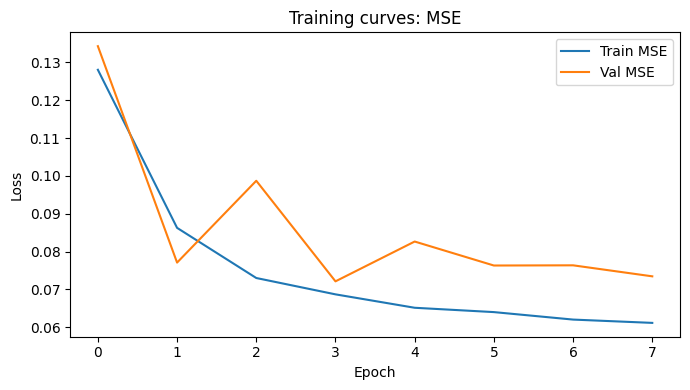

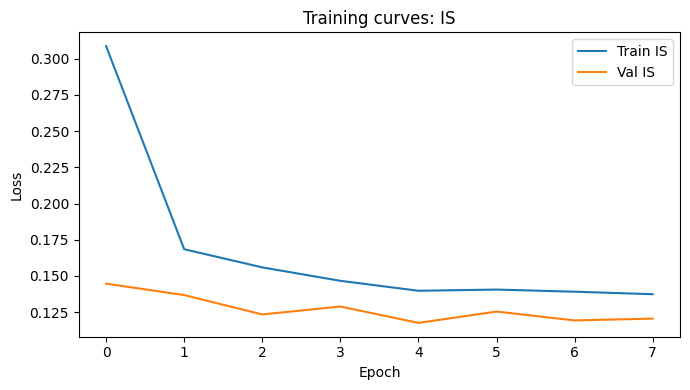

In [16]:
os.makedirs("outputs", exist_ok=True)
model_mse, tr_mse, val_mse = train_model(loss_mse, epochs=8)
model_is,  tr_is,  val_is  = train_model(loss_is,  epochs=8)

plt.figure(figsize=(7,4))
plt.plot(tr_mse, label="Train MSE"); plt.plot(val_mse, label="Val MSE")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training curves: MSE")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(tr_is, label="Train IS"); plt.plot(val_is, label="Val IS")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training curves: IS")
plt.legend(); plt.tight_layout(); plt.show()


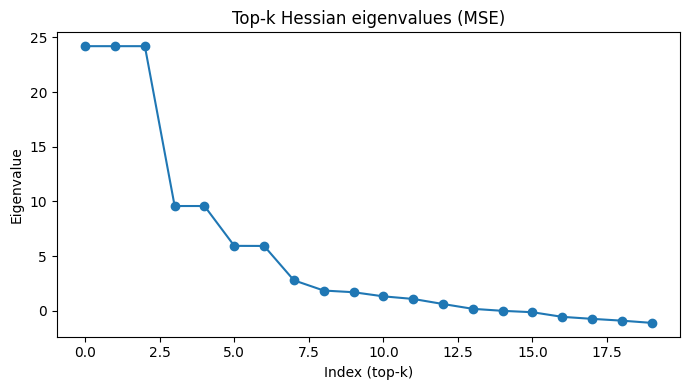

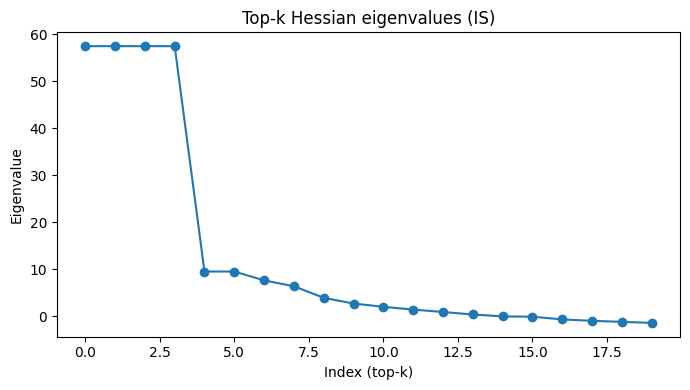

Saved results to outputs/exp_cnn1d_is_vs_mse_results.json


In [17]:
k = 20
evals_mse = topk_hessian_eigs(model_mse, loss_mse, train_loader, k=k, batch_items=24)
evals_is  = topk_hessian_eigs(model_is,  loss_is,  train_loader, k=k, batch_items=24)

plt.figure(figsize=(7,4))
plt.plot(evals_mse, marker="o")
plt.xlabel("Index (top-k)"); plt.ylabel("Eigenvalue"); plt.title("Top-k Hessian eigenvalues (MSE)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(evals_is, marker="o")
plt.xlabel("Index (top-k)"); plt.ylabel("Eigenvalue"); plt.title("Top-k Hessian eigenvalues (IS)")
plt.tight_layout(); plt.show()

with open("outputs/exp_cnn1d_is_vs_mse_results.json","w") as f:
    json.dump(dict(
        device=str(device),
        n_params=int(sum(p.numel() for p in model_mse.parameters())),
        train_mse=list(map(float,tr_mse)),
        val_mse=list(map(float,val_mse)),
        train_is=list(map(float,tr_is)),
        val_is=list(map(float,val_is)),
        topk_eigs_mse=list(map(float,evals_mse)),
        topk_eigs_is=list(map(float,evals_is)),
    ), f, indent=2)
print("Saved results to outputs/exp_cnn1d_is_vs_mse_results.json")


In [18]:
print(to_coords(evals_mse))  # colle le résultat dans \traMSE, etc.
print(to_coords(evals_is))  # colle le résultat dans \traIS, etc.

(0,24.1978) (1,24.1977) (2,24.1977) (3,9.58283) (4,9.58282) (5,5.94039) (6,5.93259) (7,2.79065) (8,1.85571) (9,1.70152) (10,1.32508) (11,1.08691) (12,0.624097) (13,0.183013) (14,0.000441237) (15,-0.127133) (16,-0.549629) (17,-0.732775) (18,-0.898343) (19,-1.10188)
(0,57.4816) (1,57.4815) (2,57.4815) (3,57.4815) (4,9.55035) (5,9.5503) (6,7.673) (7,6.4063) (8,3.9613) (9,2.73925) (10,2.04361) (11,1.45772) (12,0.940534) (13,0.410912) (14,0.00451152) (15,-0.0547486) (16,-0.634928) (17,-0.935717) (18,-1.16004) (19,-1.37374)
